## This notebook explores the effect of noise in the objective values on the results.

The ArI dataset consists of predicted rates for the oxidative addition of the aryl iodides using a Ni(I) catalyst. The rates were generated using a three-parameter regression model. As such, the data labels are very "clean". The labels in an experimental dataset would however be messier as the experimental measurement would contain measuring errors.

To investigate the effect of this on the predictions, we add different amounts of noise to the dataset labels.

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from Code.benchmark import Benchmark
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import umap
from sklearn.preprocessing import scale
import shutil
import pandas as pd
from pathlib import Path
import os
import ast
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys
wdir = Path(".")

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

## Create datasets with different levels of noise

Read in the original dataset

In [2]:
# Read in the unfiltered dataset
df_original = pd.read_csv("./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered.csv",index_col=0,header=0)
print(f"The full, unfiltered datast has {len(df_original)} entries.")

The full, unfiltered datast has 2055 entries.


In [3]:
# find the extreme rate values
print(f'The highest rate in the dataset is {df_original["rate"].max()}.')
print(f'The highest rate in the dataset is {df_original["rate"].min()}.')
print(f'The spread of rates is {df_original["rate"].max()-df_original["rate"].min()}.')

The highest rate in the dataset is 3.123.
The highest rate in the dataset is -1.214.
The spread of rates is 4.337.


The spread of rates in the dataset is 4.337. Analytical methods in organic chemistry such as NMR and GC are typically believed to yield results within 5% error which would correspond to a rate difference of 0.217. We designed noise with a standard deviation of 0.217 as the low noise level.

Additionally, we added noise with a standard deviation of 0.434 (corresponding to 10% of the data spread) as medium level noise and with a standard deviation of 0.867(corresponding to 20% of spread) as high noise.

In [4]:
# define noise levels
noise_levels = {"no": 0, "low": 0.217, "medium": 0.434, "high": 0.867}
# define a function for adding noise
np.random.seed(42)
def add_noise(df, noise_level):
    # make some noise
    noise = np.random.normal(0.0, noise_levels[noise_level], size=len(df_original))
    # Add noise to the rates
    noisy_data = df["rate"] + noise
    df_noisy = df.copy(deep=True)
    df_noisy["rate"] = noisy_data

    return df_noisy

In [5]:
# make noisy data and save it
dfs_noisy = {"no": df_original}
for noise_level in list(noise_levels.keys())[1:]:  # dataset for no noise was already prepared in another notebook
    if noise_level != "no":
        dfs_noisy[noise_level] = add_noise(df_original,noise_level)
        dfs_noisy[noise_level].to_csv(f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_{noise_level}-noise.csv",index=True,header=True)

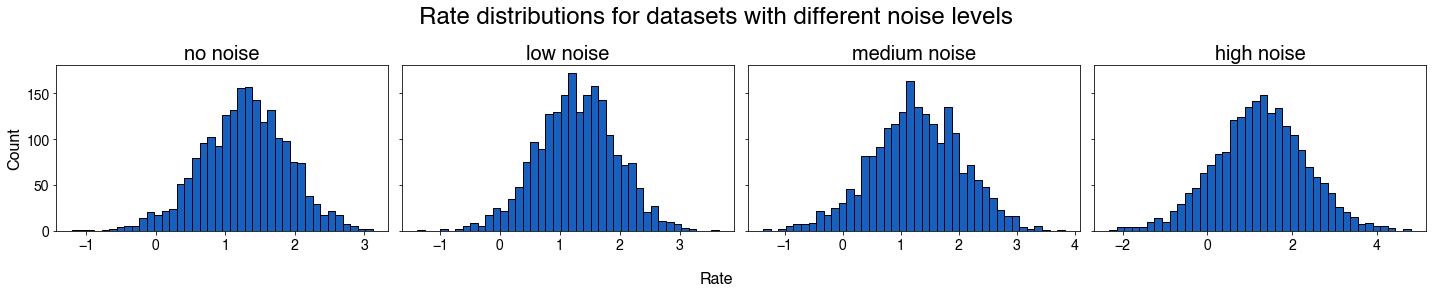

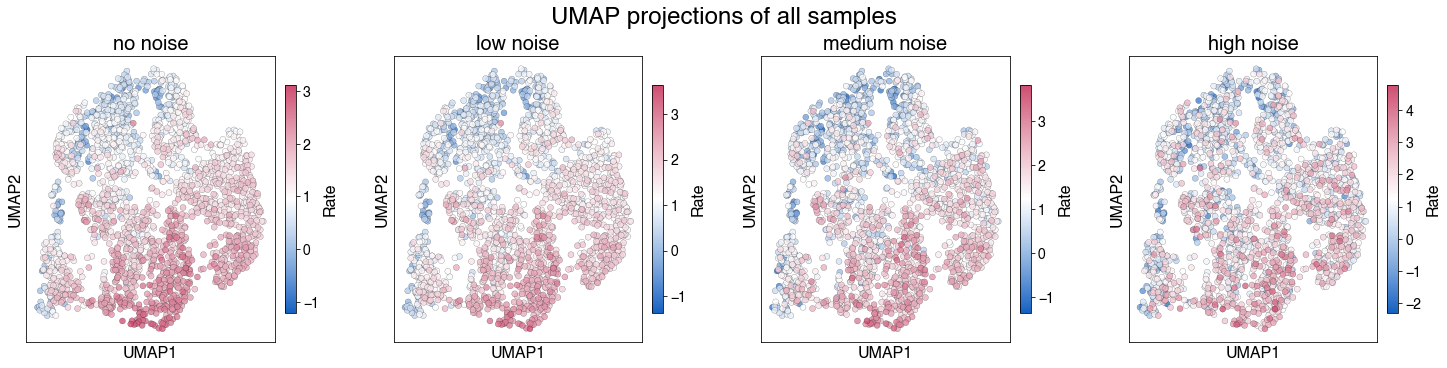

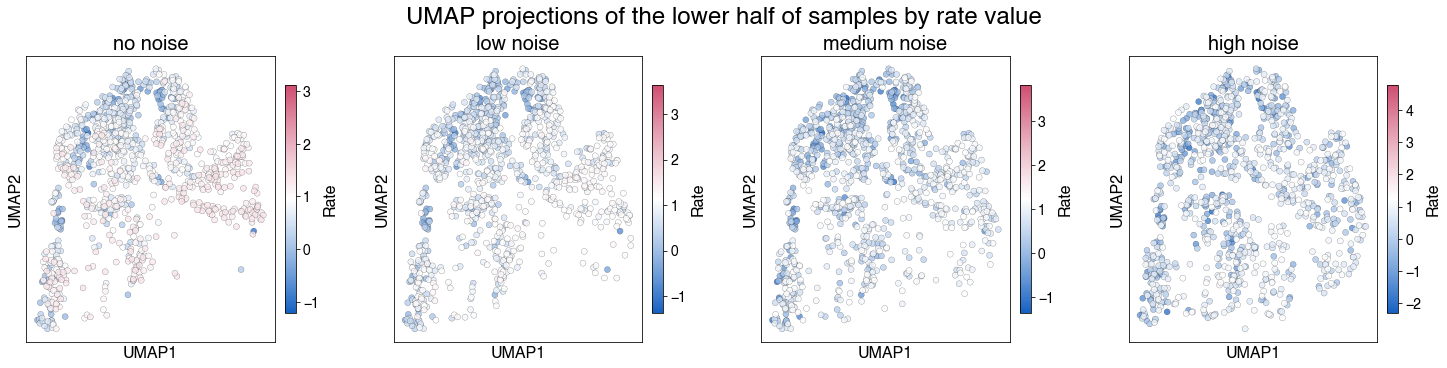

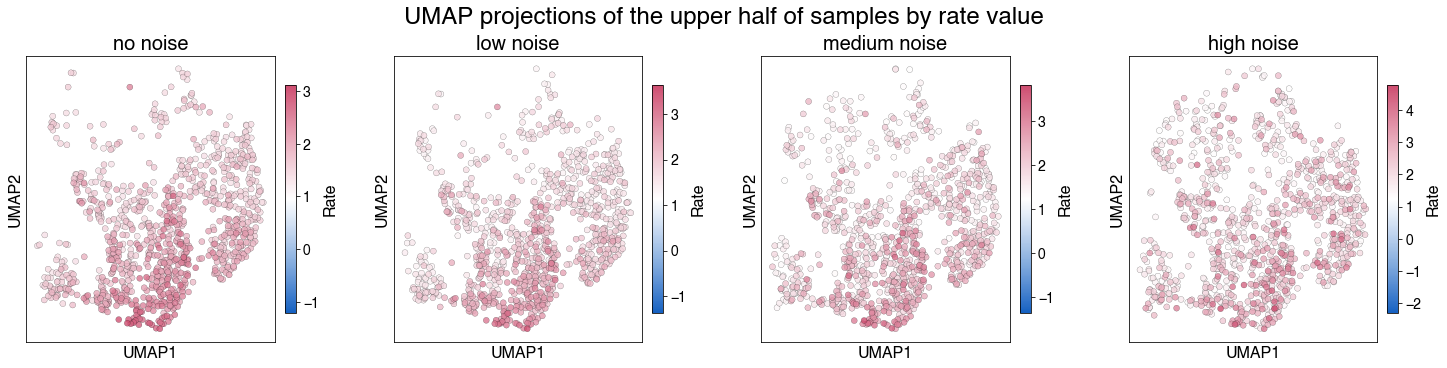

In [6]:
# Plot the distributions
fig, axes = plt.subplots(1, len(noise_levels), figsize=(20, 4), sharey=True)
fig.suptitle("Rate distributions for datasets with different noise levels",fontsize=24)
fig.supxlabel("Rate",fontsize=16)
for i,noise_level in enumerate(noise_levels):
    axes[i].hist(dfs_noisy[noise_level]["rate"], color=all_colors[1], bins=40, edgecolor="k")
    plt.tick_params(axis='both', which='major')
    axes[i].set_title(f"{noise_level} noise",fontsize=20)
    axes[i].tick_params(labelsize=14)
axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()

# Plot the UMAP for each distribution
def print_UMAP(dfs,split,title):
    fig,axes = plt.subplots(1,len(noise_levels),figsize=(20,5), gridspec_kw={"wspace": 0.1},constrained_layout=True)
    fig.suptitle(title)
    for i,noise_level in enumerate(noise_levels):
        df_data = dfs[noise_level].copy(deep=True)
        df_data = df_data.drop(columns='rate')  # drop the objective values
        df_data = pd.DataFrame(scale(df_data),df_data.index,df_data.columns)
        fit = umap.UMAP(n_neighbors=40,min_dist=0.7,n_components=2,metric="euclidean",random_state=12)
        df_umap = pd.DataFrame(fit.fit_transform(df_data),df_data.index,["UMAP1","UMAP2"])
        # map the rate data onto the UMAP
        for index in df_umap.index:
            df_umap.loc[index,"rate"] = dfs[noise_level].loc[index,"rate"]
        df_umap.sort_values(by="rate",inplace=True)
        if split == "full":
            df_plot = df_umap
        elif split == "upper":
            df_plot = df_umap.iloc[-1028:,:]
        elif split == "lower":
            df_plot = df_umap.iloc[:1028,:]
        # Add a colorbar for the 'hue' (selected/ removed points)
        norm = mpl.colors.Normalize(vmin=df_umap["rate"].min(), vmax=df_umap["rate"].max())  # Normalize the colorscale
        sns.scatterplot(data=df_plot, x="UMAP1", y="UMAP2",hue="rate", hue_norm=norm,palette="Doyle_cont",
                        ax=axes[i],legend=False,alpha=0.8,edgecolor='k', linewidth=0.2)
        axes[i].set_title(f"{noise_level} noise")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        sm = plt.cm.ScalarMappable(cmap="Doyle_cont", norm=norm)
        sm.set_array([])  # Empty array for ScalarMappable
        # add colorbar to this subplot only
        cbar = fig.colorbar(
            sm, ax=axes[i], orientation="vertical", fraction=0.046, pad=0.04)
        cbar.set_label("Rate")
    plt.show()

print_UMAP(dfs_noisy,"full","UMAP projections of all samples")
print_UMAP(dfs_noisy,"lower","UMAP projections of the lower half of samples by rate value")
print_UMAP(dfs_noisy,"upper","UMAP projections of the upper half of samples by rate value")

## Run scopes with the subsets

In [7]:
# for noise_level in list(noise_levels.keys())[1:]:  # Skip the full,unfiltered dataset (first list entry) since it was already run in another notebook
#     # dictionary with the different batches and the possible Vendi pruning fractions (larger batch = less rounds --> more pruning possible)
#     batch_pruning_combinations = {2: [0,10,20,30], 3: [0,10,20,30,40], 4: [0,10,20,30,40,50]}
#     for batch in batch_pruning_combinations.keys():
#         # run the scopes with the different settings
#         Benchmark().collect_data(
#             filename_labelled = f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_{noise_level}-noise.csv",  
#             name_results = f"./Results_Data/Noise_Dependence/{noise_level}_noise/30balanced_b{batch}",  
#             objectives=['rate'],  
#             budget = 30,
#             batches= [batch],
#             Vendi_pruning_fractions = batch_pruning_combinations[batch],
#             seeds = 20,
#             acquisition_function_mode= "balanced",
#             pruning_metric= "vendi_batch",
#             init_sampling_method="random",
#             filename_prediction="df_tuning2.csv")

In [8]:
# # copy the data for scope runs with the dataset without noise for easier processing
# shutil.copytree("./Results_Data/Reaction_Space_Size_Dependence/Full_Reaction_Space", "./Results_Data/Noise_Dependence/no_noise")

## Analyze the results

### Progress plots

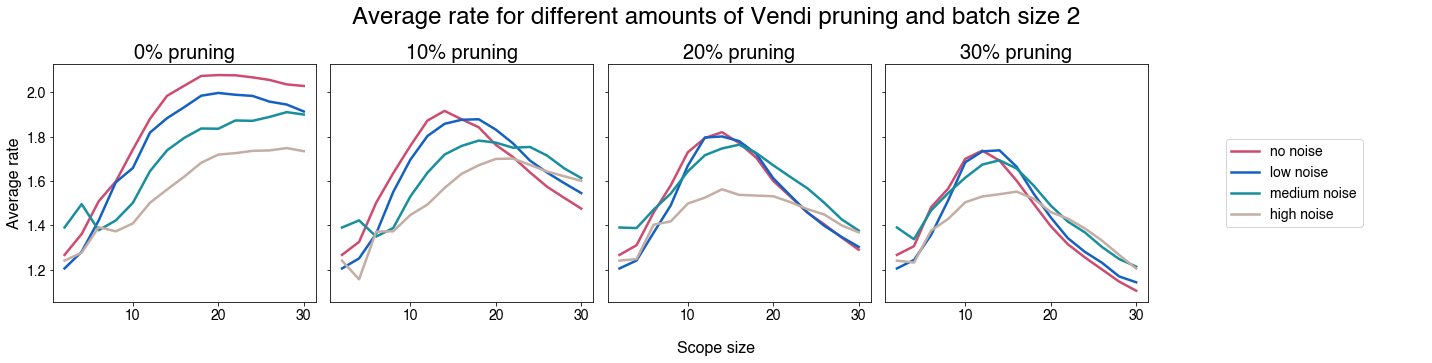

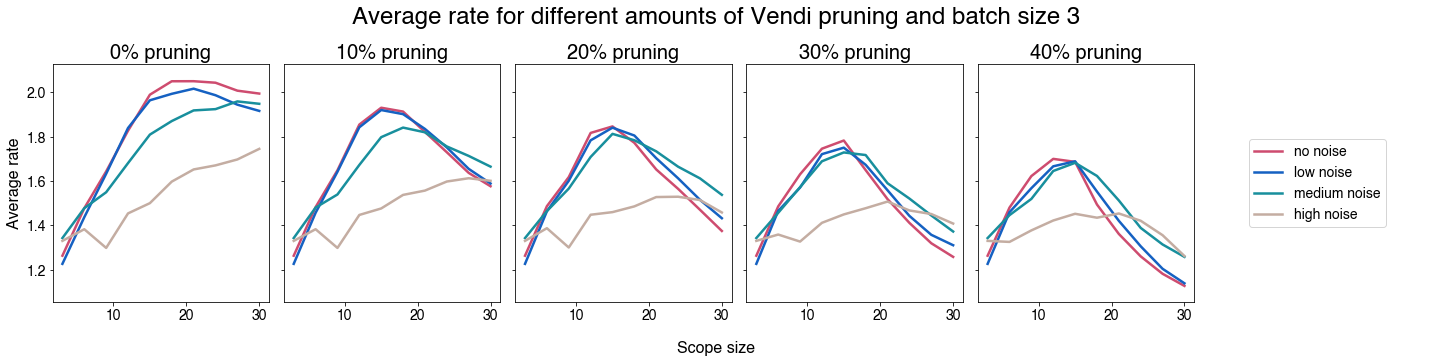

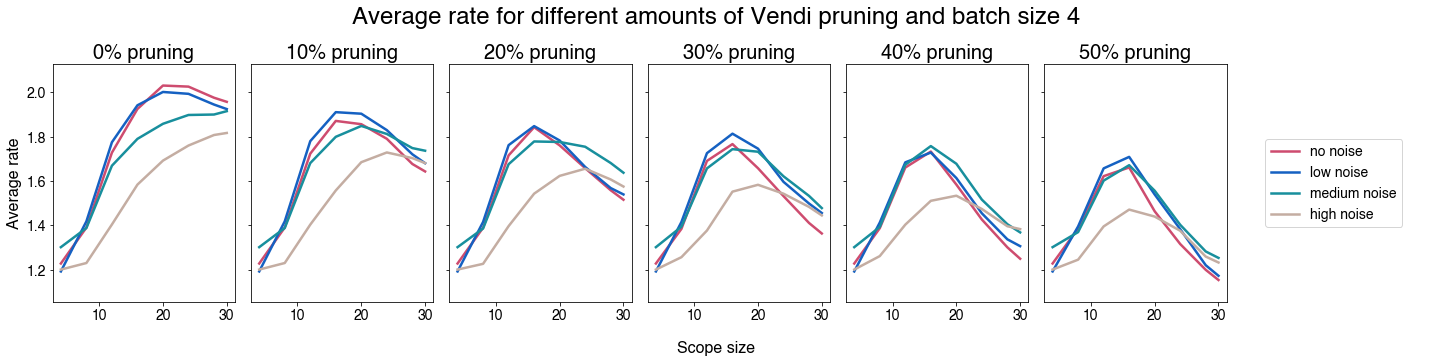

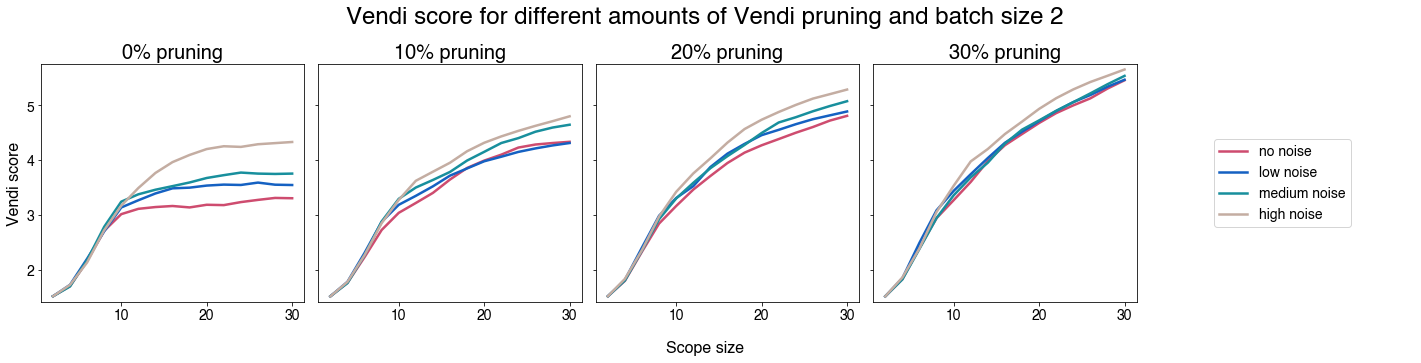

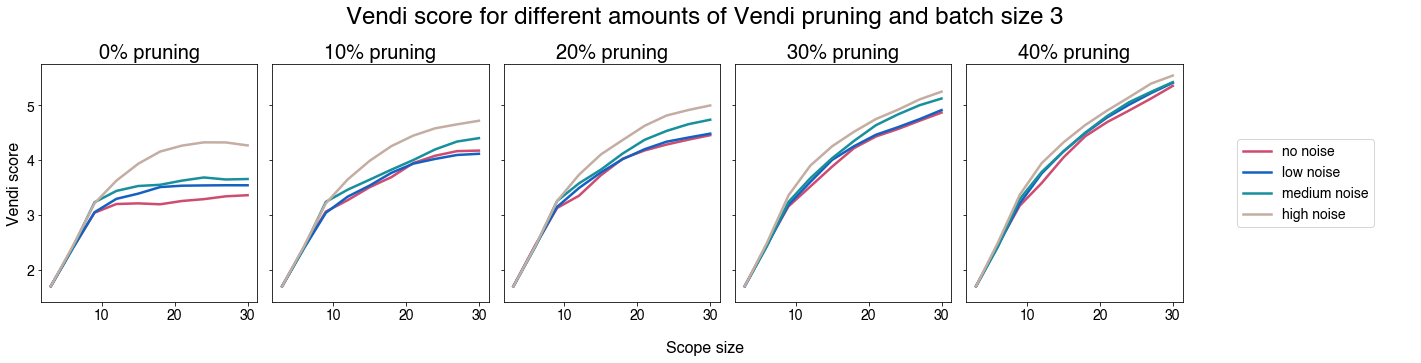

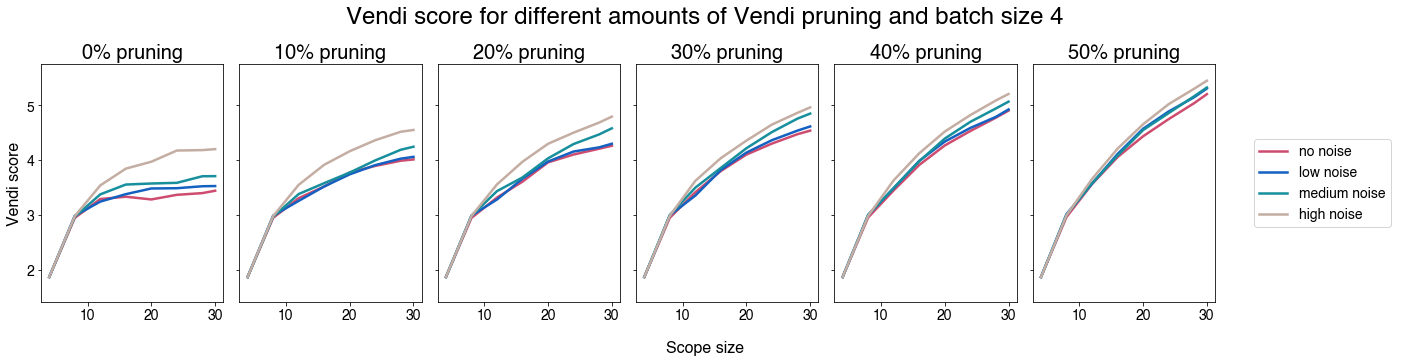

In [9]:
# Process the data
label_dict = {"no": "no noise", "low": "low noise", "medium": "medium noise", "high": "high noise"}
for type_results in ["Objective","Vendi"]:
    label = None
    dfs = {}
    for noise_level in noise_levels:
        for i in [2,3,4]:
                dfs_progress =  Benchmark().progress_plot(budget=30,type_results=type_results,
                                                                            name_results=f"./Results_Data/Noise_Dependence/{noise_level}_noise/30balanced_b{i}",
                                                                            show_plot=False)
                dfs[noise_level+f"_b{i}"] = dfs_progress["means"]

    # Concatenate the results
    df = pd.concat(dfs,axis=1)
    # Clean up the multi-index that resulted from concatenation
    df.columns = [multiidx[0].split("_")[0]+"_"+multiidx[1] for multiidx in df.columns]

    # Visualize them
    batch_pruning_combinations = {2: [0,10,20,30], 3: [0,10,20,30,40], 4: [0,10,20,30,40,50]}
    for batch in [2,3,4]:
        fig, axes = plt.subplots(1, len(batch_pruning_combinations[batch])+1, figsize=(20, 5), sharey=True)
        fig.supxlabel("Scope size",fontsize=16)
        if type_results == "Objective":
            fig.suptitle(f"Average rate for different amounts of Vendi pruning and batch size {batch}",fontsize=24)
            axes[0].set_ylabel("Average rate",fontsize=16)
        elif type_results == "Vendi":
            extreme_scores = (df.min().min(),df.max().max())
            fig.suptitle(f"Vendi score for different amounts of Vendi pruning and batch size {batch}")
            axes[0].set_ylabel("Vendi score",fontsize=16)
        for i,pruning in enumerate(batch_pruning_combinations[batch]):
            if type_results == "Objective":
                extreme_scores = (df.min().min()-0.05,df.max().max()+0.05)
            if type_results == "Vendi":
                extreme_scores = (df.min().min()-0.1,df.max().max()+0.1)
            df_plot = df.copy()
            df_plot = df_plot[[column for column in df.columns if ((f"b{batch}_V{pruning}") in column)]]
            df_plot.columns = [label_dict[col.split("_")[0]] for col in df_plot.columns]
            for j,col in enumerate(df_plot.columns):
                style = '-' if j <= 6 else '--' if j <= 13 else ':'
                plotting = df_plot[col][df_plot[col].notna()]
                axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)
            axes[i].set_ylim(extreme_scores[0],extreme_scores[1])
            axes[i].tick_params(labelsize=14)
            axes[i].set_title(f"{pruning}% pruning",fontsize=20)
            if i == 0:
                handles_collected, labels_collected = axes[i].get_legend_handles_labels()
        axes[len(batch_pruning_combinations[batch])].axis('off')
        axes[len(batch_pruning_combinations[batch])].legend(handles=handles_collected, labels=labels_collected,
            fontsize=14, loc='center')
        plt.tight_layout()
        plt.show()

Increasing the noise level leads to lowered average objectives and also increased randomness in the substrate selection. While the low and no noise datasets have similar average objective results, datasets with higher noise levels have lowered performance and the average objective values vary significantly between the rounds of the run which indicates that the model predictions are less confident.

In the case of the Vendi scores, higher noise levels lead to higher Vendi scores if there is little or no pruning. This could be attributed to more randomness in the substrate selection due to less acurrate predictions of the surrogate model. This difference in Vendi scores becomes lower with increasing pruning percentage as the substrate selection is more dictated by the Vendi pruning step in this case

### SHAP analysis

The rates in the ArI dataset were predicted using a three-parameter linear regression model using the features [NBO charge of the ipso-carbon in the aryl radical generated from the aryl iodide], [LUMO energy], and [buried volume of radius 2.0 Å for the iodine atom]. One of these features is directly in the Auto-QChem-generated DFT descriptors that is used for the dataset (LUMO) and related features for the other two regression model features are present.

Due to these similarities, the surrogate model of the prediction algorithm could potentially learn the objective data more easily than in a real-world scenario. To analyze if this is the case, we performed feature importance analysis for the scope run results using the different noise levels.

As an example, we selected to execute the feature analysis for the scopes with a batch size of 2 and 10% pruning.

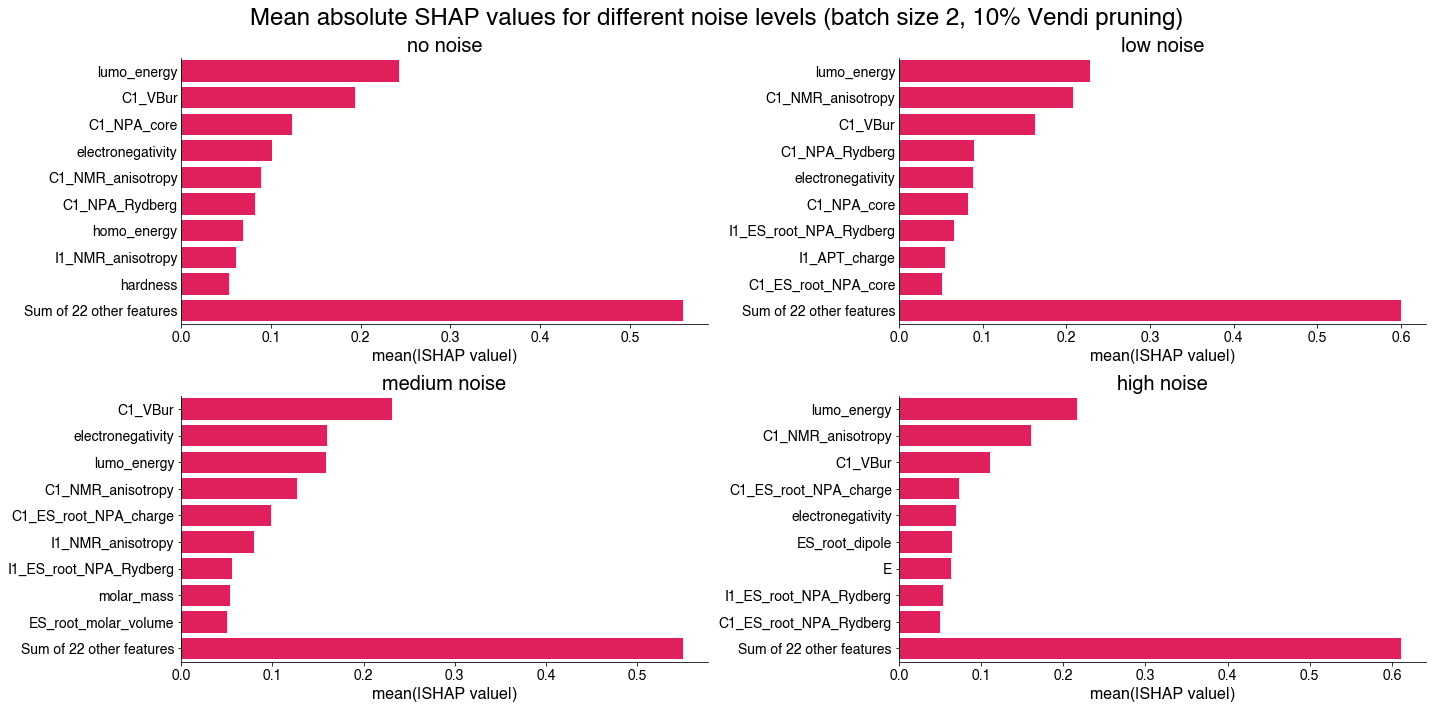

In [10]:
# Run the feature analysis for the different scopes
shap_results = {}
for noise_level in noise_levels:
    folder = f"./Results_Data/Noise_Dependence/{noise_level}_noise/30balanced_b2/raw_data"
    shap_values = []
    noise_label = ""
    if noise_level != "no":
        noise_label = f"_{noise_level}-noise"
    for filename in os.listdir(folder):
        if "V10" in filename:
            _,mean_abs_shap_values = Benchmark().feature_analysis(objectives=["rate"],filename=f"{folder}/{filename}",
                                                filename_labelled=f"./../0_Data/Datasets/Datasets_Initial_Trends"\
                                                    f"/ArI_data_dft_unfiltered{noise_label}.csv", plot_type=[])
            shap_values.append(mean_abs_shap_values)
    # The shap_values list holds the results for the different random seeds --> average them
    df_shap_results = pd.concat(shap_values, axis=1)
    average_shap = df_shap_results.mean(axis=1)
    shap_results[noise_level] = average_shap.sort_values(ascending=False)

# Summarize the least important features of each run (everything starting from the 10th most important value)
for noise_level in noise_levels:
    shap_results[noise_level].index.values[9] = f"Sum of {len(shap_results[noise_level])-9} other features"
    shap_results[noise_level].iloc[9] = shap_results[noise_level].iloc[9:].sum()
    shap_results[noise_level] = shap_results[noise_level].iloc[:10]  # drop everything form the 11th value

# Plot the shap values
fig, axes = plt.subplots(2,2, figsize=(20,10), sharey=False)
fig.suptitle("Mean absolute SHAP values for different noise levels (batch size 2, 10% Vendi pruning)")
for i,noise_level in enumerate(shap_results.keys()):
    if i < 2:
        sns.barplot(ax=axes[0][i],x=shap_results[noise_level].values, y=shap_results[noise_level].index, color="#FF0051")
        sns.despine(ax=axes[0][i], top=True,right=True)
        axes[0][i].set_title(f"{noise_level} noise")
        axes[0][i].set_xlabel("mean(|SHAP value|)")
        axes[0][i].tick_params(axis='y', length=0)
    if i >= 2:
        sns.barplot(ax=axes[1][i-2],x=shap_results[noise_level].values, y=shap_results[noise_level].index, color="#FF0051")
        sns.despine(ax=axes[1][i-2], top=True,right=True)
        axes[1][i-2].set_title(f"{noise_level} noise")
        axes[1][i-2].set_xlabel("mean(|SHAP value|)")
        axes[0][i-2].tick_params(axis='y', length=0)
plt.tight_layout()
plt.show()

Without noise, the feature importance is high for features that are in the original regression model of the rates or related to them. With added noise, the relative importance of these features decreases, indicating that the model is worse at predicting the rates. This is also seen in the drop in average rate with increasing noise level.

We decided to use high noise (std. dev. of 20% of dataset spread) for the reaction optimization.